In [1]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter as uf

from skimage.filters import threshold_otsu, threshold_local
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays   
import tiff_file 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\user-friendly-SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\user-friendly-SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\user-friendly-SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [150]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

### the SIA function 
def SIA(image, block_size, offset_val):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    SIA_details = " (raw images)"
    ### Crop image
    #image = image[:1440, :1440]    ###option to crop out any large noise features 
    if skeletonize == True:
        image = threshold_images(image, block_size, offset_val)
        SIA_details = ", (bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
    
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = np.real(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    ###           ^use "np.real()" instead of "np.abs()" b/c after subtracting mean, at large distances autocorrelation values 
    ###                in the g(r) curve should be equally likely to be either positive or negative (np.abs() is incorrect)
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr, SIA_details

### the following functions ('show_threshold_images', and 'show_filtered_images') are used to preview 
#           the images intended for analysis
def show_raw_images(ax, i, frame_key):
    #print(num_files_array[i])
    plt.gray()
    if num_files_array[i] == 0:
        test_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        test_image = tiff_file.imread(files[i],key=[frame_key])
        title = str((files[i].split('\\')[-1])[:-4]) #OPTION: frame_array[i]
        ax.set_title(title, fontsize=10) 
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(ax, i, frame_key, block_size, offset_val):
    if num_files_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i],key=[frame_key])  
        ax.set_title(" --> skeletonized", fontsize=10)
        threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image)
    ax.axis('off')
    plt.tight_layout(pad=.2)

### the function to actually threshold images 
def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500    #this seems to help generalize thresholding for my data (idrk why). change/remove as needed
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    ed_binary_im = 1*(ed_image > ed_thresh)
    binned_ed_binary_im = downscale_local_mean(ed_binary_im, (2,2), cval=1)
    return binned_ed_binary_im

## Locate your data (tiff files) and choose where to save results     

In [151]:
exp = "Lauren ims"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed --> change to your folder location
data_dir = "C:\\Users\\gleech\\Documents\\GitHub\\kai codes\\user-friendly-SIA\\"+exp +"\\" 
### "plot_saveto" is the pathway to the folder where plots and results will be saved
plot_saveto = data_dir

files = glob.glob(data_dir+"*tiff") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 2 files
 0 	 1hr_2.tiff
 1 	 28hr_4.tiff


## Specify pixel size and the time points of data collection (time_array)

In [186]:
time_array = [1, 4, 7, 10, 13, 19, 22, 25, 28]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files with '_t01_' in their filename correspond to t = 1 hour, time_array[0]

frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 

pixel_size = 1 #0.0944 #0.09436 #10.597  #0.0944
px = "pix size= "+str(pixel_size)
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

num_files = int((len(files)))
print("number of files: "+ str(num_files))

num_times = num_files         #int((len(files))/3)
print("total number of time points: "+ str(num_times))

tiff file dimensions: (525, 525)
number of files: 2
total number of time points: 2


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [187]:
fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 600
### image quality level (recommendation: 600)

<hgroup>
	<h1>For better results on noisy images, we can use local thresholding to 'skeletonize' the images before analysis</h1>
	<p><strong>To skeletonize images, set "skeletonize = True". Thanks to scikit-image!</strong><br> 
    <i>The lines in quotes below are copied from their webpage, see <a href="https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html">scikit-image.org</a> for more info</i></p>
</hgroup>
<p>"Thresholding is used to create a binary image from a grayscale image 1. It is the simplest way to segment objects from a background" </p>
<i>Skeletonize</i> means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r). 
<p><strong>Local thresholding:</strong><br>
    "Here, we binarize an image using the <strong>threshold_local function</strong>, which calculates thresholds in regions with a characteristic size <strong>block_size</strong> surrounding each pixel (i.e. local neighborhoods). Each threshold value is the weighted mean of the local neighborhood minus an <strong>offset value</strong>"</p>
<hgroup>

In [188]:
### NOTE: this make take a while if you have many and/or large images
### "i" --> this value determines which file index to start at 
i = 0   
num_files = int((len(files)))  ### change "num_files" to a smaller number to skeletonize less images more quickly (e.g. 2)
print("preview images for "+exp+", files "+ str(i) + " - " + str(num_files - 1 + i) )

frame_key = 0 ### "frame_key" specifies which frame of a tiff "tiff_file.imread()" will read, i.e. "key = 0" selects frame 1

skeletonize = False ### change this to 'True' to skeletonize images
block_size = 1051 ### the number of pixels used for local thresholding, you might try ~half your image size to start
offset_val = -20  ### adjust the threshold according to your needs (e.g. -20 increases the threshold by 20)

### this code sets up the figure for skeletonized images to be shown
num_files_array = [1]* (num_files + i)
if num_files % 2 != 0:
    num_files_array.append(0)
    num_files = num_files + 1
num_rows = int((num_files/4))
if skeletonize == True:
    num_rows = num_rows*2
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if skeletonize == True:
        if j % 2 == 0:
            show_raw_images(ax, i, frame_key)
        else:
            show_threshold_images(ax, i, frame_key, block_size, offset_val)
            i = i + 1 
        details = exp+ ", %3.1f files (block_size= %3i, offset= %3i)" %((i+1), block_size, offset_val)
    else:
        show_raw_images(ax, i, frame_key)
        i = i + 1 
        details = exp+ ", %i files (raw images)" %(i+1)
plt.show()

print("preview images for "  + details)
### option to save this figure (uncomment below)
fig.savefig(plot_saveto + "preview images for " + details + ".jpg", dpi=dpi_num)

preview images for Lauren ims, files 0 - 1


<IPython.core.display.Javascript object>

ValueError: Number of rows must be a positive integer, not 0

## Now we can run some SIA! 

running SIA on 1hr_2., frame 1 ...


<IPython.core.display.Javascript object>


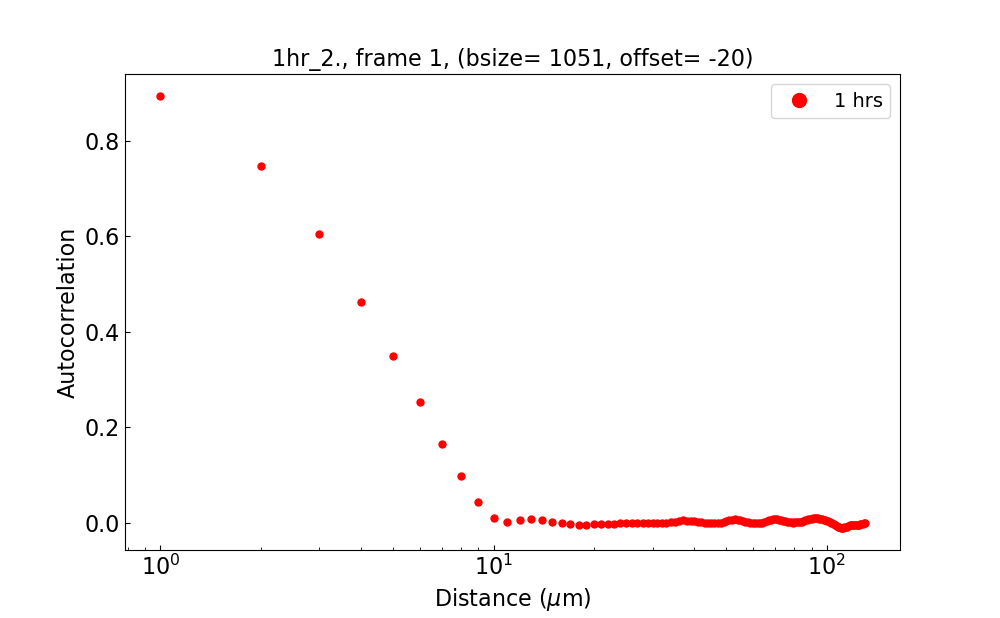

image size: 525 x 525 pixels
radius of radially averaged image: 130.000 um, last x-value= 130.000 um


In [189]:
file_index = 0
frame_key = 0
file_details = str((files[file_index].split('\\')[-1])[:-4]) + ", frame " + str(frame_key +1)
print("running SIA on " + file_details + " ...")

skeletonize = True     #change if desired
block_size = block_size #change if desired
offset_val = offset_val #change if desired

### Set basic plot design 
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 10
color = 'red' #change if desired

### "g_of_r_curve" is the g(r) correlation data from SIA analysis, these are discrete data points 
g_of_r_curve = []
image_array = tiff_file.imread(files[file_index], key=[frame_key])
g_of_r_curve, SIA_details = SIA(image_array, block_size, offset_val)
    
### corresponding x-values calculated according to the radial average size of the image multipled by "pixel_size" (um/px)
xvalues = np.arange(len(g_of_r_curve))*pixel_size

### plot the results
plt.semilogx(xvalues, g_of_r_curve, '.', ms=markerSize, c=color, label = (str(time_array[file_index]) + " hrs")) 

print("image size: %2i x %2i pixels" %tuple(image_array.shape))
print("radius of radially averaged image: %5.3f um, last x-value= %5.3f um" %(xvalues[-1], xvalues[-1]))

### legend, labels and title for the plot 
### **note: the title determined in this code block carries over to all other plots unless otherwise specified 
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
ax.tick_params(direction='in', which='both', labelsize=font_size)

### set title
title = file_details + SIA_details #+" no bin "
plt.title(title, fontsize=font_size)
plt.show()

In [190]:
###save figure 
fig.savefig(plot_saveto + "SIA data for " + title + px + ".jpg", dpi=dpi_num)

## Now we fit the SIA curves to a single exponential

In [191]:
###define the single exponential we use to fit SIA curves
str_equation = False
def single_exponential(x, A, cl):
    if str_equation == True:
        return "(1-A)*exp(-x/cl) + A" 
    else:
        return (1-A)*(np.exp(-x/cl)) + A

fit_line_color = 'blue'

<IPython.core.display.Javascript object>


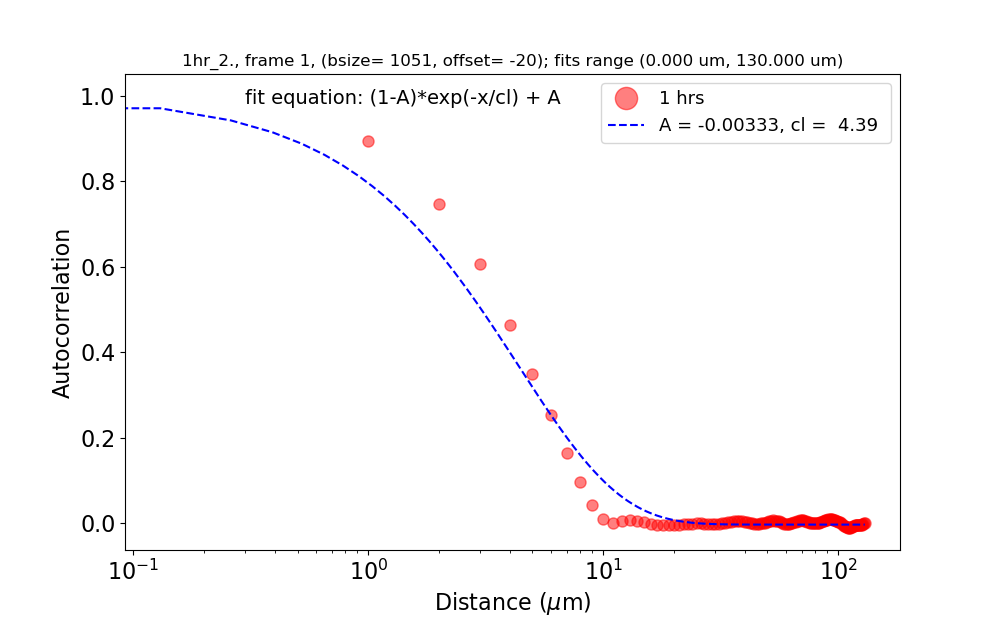

xvalues[0]= 0.000, xvalues[1]= 1.000, start fits at 0.000; fit until xlim = 130.000
fit results: A=-0.003, l1=4.393


Text(0.5, 1.0, '1hr_2., frame 1, (bsize= 1051, offset= -20); fits range (0.000 um, 130.000 um)')

In [192]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 0
fit_lim = -1 
x_fit_lim = xvalues[fit_lim]
print("xvalues[0]= %5.3f, xvalues[1]= %5.3f, start fits at %5.3f; fit until xlim = %5.3f" %(xvalues[0], xvalues[1],
                                                                                            xvalues[fit_start], x_fit_lim))

### plot the SIA curve first
y_array = []
y_array = g_of_r_curve
plt.semilogx(xvalues, y_array, 'o', ms=markerSize, c=color, alpha=0.5, label = (str(time_array[file_index]) + " hrs")) 

### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
x_fit_values = np.linspace(xvalues[fit_start], xvalues[fit_lim], 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
popt, pcov = curve_fit(single_exponential, xvalues[fit_start:fit_lim], y_array[fit_start:fit_lim])
print('fit results: A=%5.3f, l1=%5.3f' % tuple(popt))
A, cl = tuple(popt)

### generate and plot curves based on the fits 
g_of_r_fit_values = single_exponential(x_fit_values, *popt)
plt.plot(x_fit_values, g_of_r_fit_values,'--',c= fit_line_color, label = "A = %5.5f, cl = %5.2f " %(A, cl))
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)

'''plt.ylim(0.1,1)
plt.xlim(0,6)'''

str_equation = True
equation = single_exponential(x_fit_values, *popt)
ax.text(0.3,0.98, "fit equation: " + equation, fontsize=font_size-2)
str_equation = False

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)

In [193]:
###save figure
fig.savefig(plot_saveto + "SIA fit for " + title + px + ".jpg", dpi=dpi_num)

## And that's it! 
#### (I may add some options for saving data soon)